In [1]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import pandas as pd
import numpy as np
!pip install geopandas
import geopandas as gpd

from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset

!pip install tsaug
!pip install lightly

     |████████████████████████████████| 1.0 MB 3.2 MB/s 
     |████████████████████████████████| 6.3 MB 33.9 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 273 kB 3.5 MB/s 
     |████████████████████████████████| 145 kB 61.6 MB/s 
     |████████████████████████████████| 1.0 MB 53.0 MB/s 
     |████████████████████████████████| 112 kB 71.5 MB/s 
     |████████████████████████████████| 74 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 67.5 MB/s 
     |████████████████████████████████| 829 kB 76.8 MB/s 
     |████████████████████████████████| 125 kB 56.8 MB/s 
     |████████████████████████████████| 329 kB 58.5 MB/s 
     |████████████████████████████████| 1.1 MB 31.5 MB/s 
     |████████████████████████████████| 160 kB 60.9 MB/s 
     |████████████████████████████████| 192 kB 61.4 MB/s 
     |████████████████████████████████| 271 kB 75.3 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4

In [2]:
#load get data for bavaria

!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Training_bavaria.xlsx
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Test_bavaria.xlsx
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/Test_area.shp
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/Test_area.shx

!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/data2016-2018.xlsx
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/TestData.xlsx


--2021-11-04 20:26:18--  https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Training_bavaria.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6413030 (6.1M) [application/octet-stream]
Saving to: ‘Training_bavaria.xlsx’

Training_bavaria.xl 100%[===================>]   6.12M  --.-KB/s    in 0.09s   

2021-11-04 20:26:18 (69.2 MB/s) - ‘Training_bavaria.xlsx’ saved [6413030/6413030]

--2021-11-04 20:26:18--  https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Test_bavaria.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

In [3]:
def printConfusionResults(confusion):
    ''' confusion matrix: 
    Input: dataframe with ['y_pred'] and ['y_test'] columns '''
    
    #PA
    tmp = pd.crosstab(confusion["y_test"],confusion["y_pred"],margins=True,margins_name='Total').T
    tmp['UA']=0
    for idx, row in tmp.iterrows(): 
        #print(idx)
        tmp['UA'].loc[idx] = round(((row[idx])/ row['Total']*100),2)

    #UA
    tmp2 = pd.crosstab(confusion["y_test"],confusion["y_pred"],margins=True,margins_name='Total')
    tmp['PA']=0
    for idx, row in tmp2.iterrows(): 
        #print(row[idx],row.sum())
        tmp['PA'].loc[idx] = round(((row[idx])/ row['Total'])*100,2)


    #hier überprüfen ob alles stimmt

    print('Diag:', tmp.values.diagonal().sum()-tmp['Total'].tail(1)[0] )
    print('Ref:', tmp['Total'].tail(1).values[0])
    oa = (tmp.values.diagonal().sum() - tmp['Total'].tail(1)[0]) / tmp['Total'].tail(1)[0]
    print('OverallAccurcy:',oa)

    print('Kappa:',round(sklearn.metrics.cohen_kappa_score(confusion["y_pred"],confusion["y_test"],weights='quadratic'),4))
    print('#########')
    print("Ac:",round( sklearn.metrics.accuracy_score(confusion["y_pred"],confusion["y_test"]) ,4))
    print(tmp)

In [4]:
durnast = gpd.read_file('Test_area.shp')


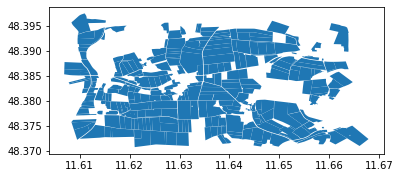

In [5]:
durnast.plot()

In [6]:
bavaria_train = pd.read_excel(
    "Training_bavaria.xlsx")
bavaria_test = pd.read_excel(
    "Test_bavaria.xlsx")

bavaria_reordered = pd.read_excel(
    'data2016-2018.xlsx', index_col=0)
bavaria_test_reordered = pd.read_excel(
    'TestData.xlsx', index_col=0)

bavaria_test.drop(['Unnamed: 0'], axis=1, inplace=True)
bavaria_train.drop(['Unnamed: 0'], axis=1, inplace=True)

bavaria_train.Date = bavaria_train.Date.dt.strftime('%m-%d')

In [7]:
#example
bavaria_train[bavaria_train.id == 3].head()

,id,Date,area,NC,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B8A_mean,B9_mean,B10_mean,B11_mean,B12_mean,NDVI_mean,NDRE_mean,REIP_mean
42,3,02-15,1.669288,115,1437.408525,1131.222058,994.990186,881.760738,1248.280942,1998.008720,2203.317183,2115.370865,2284.080789,1004.383399,16.122173,1639.231340,969.187531,0.411303,0.257565,715.652466
43,3,02-28,1.669288,115,1437.408525,1131.222058,994.990186,881.760738,1248.280942,1998.008720,2203.317183,2115.370865,2284.080789,1004.383399,16.122173,1639.231340,969.187531,0.411303,0.257565,715.652466
44,3,03-15,1.669288,115,1437.408525,1131.222058,994.990186,881.760738,1248.280942,1998.008720,2203.317183,2115.370865,2284.080789,1004.383399,16.122173,1639.231340,969.187531,0.411303,0.257565,715.652466
45,3,03-30,1.669288,115,1381.442542,1079.876260,946.509415,809.122362,1153.007076,2105.881743,2478.358594,2381.870470,2590.939675,1064.989573,20.644539,1560.514097,906.015050,0.480065,0.336062,718.646294
46,3,04-15,1.669288,115,1325.476559,1028.530462,898.028644,736.483986,1057.733210,2213.754767,2753.400004,2648.370074,2897.798560,1125.595746,25.166906,1481.796853,842.842569,0.548828,0.414559,721.640123


In [8]:
bavaria = bavaria_train

#adapt crop codex train
bavaria.loc[(bavaria.NC == 601)|(bavaria.NC == 602), 'NC'] = 600  #Kartoffeln jetzt alle Code 600
bavaria.loc[(bavaria.NC == 131)|(bavaria.NC == 476), 'NC'] = 131  #Wintergerste jetzt alle Code 131
bavaria.loc[(bavaria.NC == 411)|(bavaria.NC == 171)|(bavaria.NC == 410)|(bavaria.NC == 177), 'NC'] = 400  #Mais jetzt alle Code 400
bavaria.loc[(bavaria.NC == 311)|(bavaria.NC == 489), 'NC'] = 311  #Winterraps jetzt alle Code 311
#WW = 115
#ZR = 603
bavaria.loc[~((bavaria.NC == 600)|(bavaria.NC == 131)|(bavaria.NC == 400)|(bavaria.NC == 311)|(bavaria.NC == 115)|(bavaria.NC == 603)), 'NC'] = 1  

#assign codes to test area
bavaria_test.NC = bavaria_test.NC.astype(str).astype(int)
bavaria_test.loc[(bavaria_test.NC == 410), 'NC'] = 400  #Corn
bavaria_test.loc[~((bavaria_test.NC == 600)|(bavaria_test.NC == 131)|(bavaria_test.NC == 400)|(bavaria_test.NC == 311)|(bavaria_test.NC == 115)|(bavaria_test.NC == 603)), 'NC'] = 1  #rejection class other


In [9]:
#we have 7 classes
bavaria_train.NC.unique()

array([115, 131, 603, 400, 311, 600,   1])

In [10]:
import numpy as np
from tqdm import tqdm

class OwnAugmentation():

  def jitter(x, sigma=0.03):
      # https://arxiv.org/pdf/1706.00527.pdf
      return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

  def scaling(x, sigma=0.1):
      # https://arxiv.org/pdf/1706.00527.pdf
      factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[1]))
      return np.multiply(x, factor[:,:])


from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise
my_augmenter = (
     #TimeWarp() * 5  # random time warping 5 times in parallel
     #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
     #Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     AddNoise(scale=0.1)
     #+ Reverse() @ 0.5  # with 50% probability, reverse the sequence 
)

In [11]:
class TimeSeriesDataSet(Dataset):
    '''
    :param data: dataset of type pandas.DataFrame
    :param target_col: targeted column name
    :param feature_list: list with target features
    '''

    def __init__(self, data, feature_list, target_col):
        self.xy = data
        self.target_col = target_col
        self.feature_list = feature_list

    def __len__(self):
        return len(self.xy.id.unique())

    def __getitem__(self, field_idx):

        x = self.xy[self.xy.id == field_idx][self.feature_list].values
        y = self.xy[self.xy.id == field_idx][self.target_col].values

        torchx = self.x2torch(x)
        torchy = self.y2torch(y)

        #augmentation with jitter and scaling
        aug_x1 = self.x2torch(OwnAugmentation.jitter(x))
        aug_x2 = self.x2torch(OwnAugmentation.scaling(x))

        return (aug_x1, aug_x2), torchx, torchy
        #return torchx, torchy
        
    def x2torch(self, x):
        '''
        return torch for x
        '''
        #nb_obs, nb_features = self.x.shape
        return torch.from_numpy(x).type(torch.FloatTensor)

    def y2torch(self, y):
        '''
        return torch for y
        '''
        y = y[1]
        return torch.tensor(y, dtype=torch.long)


In [12]:
feature_list = bavaria.columns[bavaria.columns.str.contains('B')]
dataset = TimeSeriesDataSet(bavaria, feature_list.tolist(), 'NC')
print(feature_list)
print(dataset.xy.Date)
dataloader = DataLoader(dataset,batch_size=1,shuffle=True,drop_last=False,num_workers=2)

Index(['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean',
       'B7_mean', 'B8_mean', 'B8A_mean', 'B9_mean', 'B10_mean', 'B11_mean',
       'B12_mean'],
      dtype='object')
0        02-15
1        02-28
2        03-15
3        03-30
4        04-15
         ...  
29381    06-30
29382    07-15
29383    07-30
29384    08-15
29385    08-30
Name: Date, Length: 29386, dtype: object


In [13]:
augmentation, _, y = dataset[100]
y

tensor(131)

In [14]:
augmentation[1].numpy().shape

(14, 13)

Crop type: tensor([603])


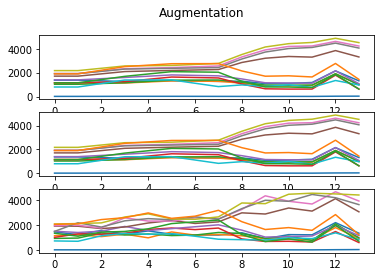

In [15]:
#visualize a batch of timeseries

import matplotlib.pyplot as plt

def plot_batch(augmentation, timeseries, labels):
  fig, axs = plt.subplots(3)
  fig.suptitle('Augmentation')

  #x  = timeseries[:,bands_idxs]
  axs[0].plot(timeseries.numpy().reshape(14,13), "-")
  axs[1].plot(augmentation[0].numpy().reshape(14,13), "-")
  axs[2].plot(augmentation[1].numpy().reshape(14,13), "-")


  print("Crop type:", labels)
  plt.show()

for i, data in enumerate(dataloader):
  # print(data[0][0][0][0].shape)
  # print(data)
  # break
  if (i>0):
    break
  aug, timeseries, labels = data
  plot_batch(aug, timeseries, labels)
  



# *Pretrain Transformer/LSTM*

In [16]:
%%capture
!pip install breizhcrops
import breizhcrops as bc

In [17]:
# initialize and download FRH04 data
dataset = bc.BreizhCrops("belle-ile")

classmapping.csv: 8.19kB [00:00, 11.8kB/s]
belle-ile.csv: 98.3kB [00:01, 94.5kB/s]                           


downloading breizhcrops_dataset/2017/L1C/belle-ile.h5.tar.gz


belle-ile.h5.tar.gz: 11.1MB [00:19, 561kB/s]                            


extracting breizhcrops_dataset/2017/L1C/belle-ile.h5.tar.gz to breizhcrops_dataset/2017/L1C/belle-ile.h5
removing breizhcrops_dataset/2017/L1C/belle-ile.h5.tar.gz
checking integrity by file size...
ok!


codes.csv: 24.6kB [00:00, 42.1kB/s]                            


In [18]:
# load pretrained model
model_tf = bc.models.pretrained("Transformer")

new_TransformerEncoder_input-dim%3D13_num-classes%3D9_d-model%3D64_d-inner%3D128_n-layers%3D5_n-head%3D2_dropout%3D0.017998950510888446_learning-rate%3D0.00017369201853408445_weight-decay%3D3.5156458637523697e-06.pth: 696kB [00:01, 361kB/s]                           


In [19]:
model_lstm = bc.models.pretrained("LSTM")

LSTM_input-dim%3D13_num-classes%3D9_hidden-dims%3D128_num-layers%3D4_bidirectional%3DTrue_use-layernorm%3DTrue_dropout%3D0.5713020228087161_learning-rate%3D0.009880117756170353_weight-decay%3D5.256755602421856e-07.pth: 5.38MB [00:09, 561kB/s]                            


In [20]:
# get data sample
x, y, field_id = dataset[0]

In [21]:
x = x.unsqueeze(0)
x.shape

torch.Size([1, 45, 13])

In [22]:
y_pred = model_tf(x)

In [23]:
model_tf.children()

<generator object Module.children at 0x7f3b042acf50>

In [24]:
dataset_index = 13 
level ="L1C"
import datetime

from breizhcrops.datasets.breizhcrops import BANDS as allbands
from breizhcrops.datasets.breizhcrops import SELECTED_BANDS as selectedbands

target_bands = ['B2', 'B3', 'B4','B5', 'B6', 'B7', 'B8', 'B8A','B11', 'B12']

def get_interpolate_transform(interpolation_frequency, interpolation_method):

  def interpolate_transform(input_timeseries):
    #input_timeseries = raw_transform(input_timeseries)
    #print(len(selectedbands[level]))
    data = pd.DataFrame(input_timeseries, columns=selectedbands[level])
    data["doa"] = pd.to_datetime(data["doa"])
    data = data.set_index("doa")
    #data = data.reindex(pd.date_range(start=datetime.datetime(data.index[0].year,1,1),
    #                            end=datetime.datetime(data.index[0].year,12,31),
    #                            freq=interpolation_frequency))
    data = data.loc[str(data.index[0].year)+'-02-01':str(data.index[0].year)+'-08-15']
    #data = data.interpolate(method=interpolation_method)
    data = data.fillna(method="ffill").fillna(method="bfill")
    data = data[target_bands] * 1e-4
    return data #torch.from_numpy(data.to_numpy()).type(torch.FloatTensor)
  return interpolate_transform

dataset = bc.BreizhCrops(region="belle-ile", level=level, transform=get_interpolate_transform("14D", "linear"))
x,y,field_id = dataset[dataset_index]



In [25]:
x,y,field_id = dataset[2]



In [26]:
field_id

6028961

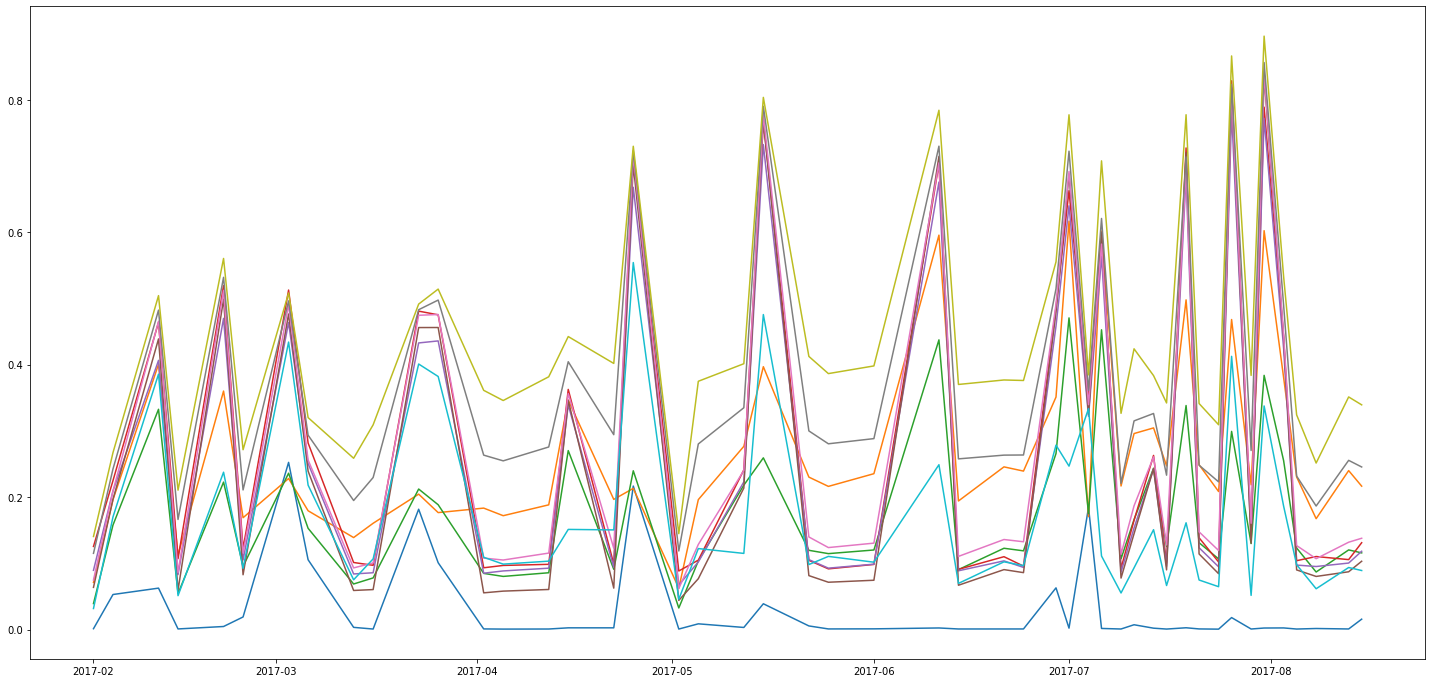

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(25,12), sharex=True, sharey=True)
x,y,i = dataset[4]

axs.plot(x.index,x)

# **Models**

In [28]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU

class TransformerModel(nn.Module):
    def __init__(self, input_dim=13, num_classes=9, d_model=64, n_head=2, n_layers=5,
                 d_inner=128, activation="relu", dropout=0.017998950510888446):

        super(TransformerModel, self).__init__()

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)
        self.flatten = Flatten()
        self.outlinear = Linear(d_model, num_classes)

    def forward(self,x):
        x = self.inlinear(x)
        x = self.relu(x)
        x = x.transpose(0, 1) # N x T x D -> T x N x D
        x = self.transformerencoder(x)
        x = x.transpose(0, 1) # T x N x D -> N x T x D
        x = x.max(1)[0]
        x = self.relu(x)
        logits = self.outlinear(x)

        logprobabilities = F.log_softmax(logits, dim=-1)
        return logprobabilities


class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)


class LSTM(torch.nn.Module):
    def __init__(self, input_dim=13, num_classes=9, hidden_dims=128, num_layers=4, dropout=0.5713020228087161, bidirectional=True, use_layernorm=True):

        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.use_layernorm = use_layernorm

        self.d_model = num_layers * hidden_dims

        if use_layernorm:
            self.inlayernorm = nn.LayerNorm(input_dim)
            self.clayernorm = nn.LayerNorm((hidden_dims + hidden_dims * bidirectional) * num_layers)

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dims, num_layers=num_layers,
                            bias=False, batch_first=True, dropout=dropout, bidirectional=bidirectional)

        if bidirectional:
            hidden_dims = hidden_dims * 2

        self.linear_class = nn.Linear(hidden_dims * num_layers, num_classes, bias=True)


    def logits(self, x):

        if self.use_layernorm:
            x = self.inlayernorm(x)

        outputs, last_state_list = self.lstm.forward(x)

        h, c = last_state_list

        nlayers, batchsize, n_hidden = c.shape
        h = self.clayernorm(c.transpose(0, 1).contiguous().view(batchsize, nlayers * n_hidden))
        logits = self.linear_class.forward(h)

        return logits

    def forward(self, x):
        logprobabilities = F.log_softmax(self.logits(x), dim=-1)
        return logprobabilities


import torch.nn as nn
class BackboneLSTM(nn.Module):
    # See also https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    # See also https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
    def __init__(self, num_input_channels: int=13, embedding_size: int=32):
        self.lstm = nn.LSTM(num_input_channels, embedding_size, batch_first=True)

    def forward(self, input_batch):
        """

        Args:
            input_batch:
                shape: (batch_size, no_timesteps, num_input_channels)

        """
        output, (h_n, c_n) = self.lstm(input_batch)
        return h_n

In [29]:
test = TransformerModel(input_dim =13,num_classes=7, d_model=14)

In [30]:
nn.Sequential(*list(test.children()))

Sequential(
  (0): Linear(in_features=13, out_features=14, bias=True)
  (1): ReLU()
  (2): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=14, out_features=14, bias=True)
        )
        (linear1): Linear(in_features=14, out_features=128, bias=True)
        (dropout): Dropout(p=0.017998950510888446, inplace=False)
        (linear2): Linear(in_features=128, out_features=14, bias=True)
        (norm1): LayerNorm((14,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((14,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.017998950510888446, inplace=False)
        (dropout2): Dropout(p=0.017998950510888446, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=14, out_features=14, bias=True)
        )
   


# *Train Supervised Test*

In [36]:
dataloader

In [37]:
dataiter = iter(dataloader)
aug, _, _ = dataiter.next()
print(type(aug))
print(aug[0].shape)
print(_.shape)

<class 'list'>
torch.Size([1, 14, 13])
torch.Size([1])


In [38]:
test

TransformerModel(
  (inlinear): Linear(in_features=13, out_features=14, bias=True)
  (relu): ReLU()
  (transformerencoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=14, out_features=14, bias=True)
        )
        (linear1): Linear(in_features=14, out_features=128, bias=True)
        (dropout): Dropout(p=0.017998950510888446, inplace=False)
        (linear2): Linear(in_features=128, out_features=14, bias=True)
        (norm1): LayerNorm((14,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((14,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.017998950510888446, inplace=False)
        (dropout2): Dropout(p=0.017998950510888446, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=14, out_feat

In [42]:
dataset2 = bc.BreizhCrops(region="belle-ile")
x,y,field_id = dataset2[dataset_index]

dataloader2 = DataLoader(dataset2,batch_size=1,shuffle=True,drop_last=False,num_workers=2)

In [54]:
X.shape

torch.Size([1, 45, 13])

In [53]:
import torch
import tqdm

model = breizhcrops.models.TransformerModel()


model.train()
dataset = bc.BreizhCrops("belle-ile")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(5):
  with tqdm.tqdm(enumerate(dataloader),total=(len(dataloader))) as pbar:
    for idx, batch in pbar:
      optimizer.zero_grad()    
      X,y,field_ids = batch
      y_pred = model(X)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"idx {idx}: loss {loss:.2f}")

idx 101: loss 0.06:  10%|▉         | 101/1049 [00:02<00:19, 48.39it/s]


KeyboardInterrupt: ignored

# *Lightly SimSiam*

In [31]:
import math
import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import BatchNorm1d
import torchvision
import numpy as np
import lightly

<class 'list'>
torch.Size([1, 14, 13])
torch.Size([1])


In [33]:
num_workers = 8
batch_size = 1
seed = 1
epochs = 50

#input size (timesteps x channels)
input_size = 14

# dimension of the embeddings
num_ftrs = 28
# dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 28
# the prediction head uses a bottleneck architecture
pred_hidden_dim = 10

# seed torch and numpy
torch.manual_seed(0)
np.random.seed(0)



In [34]:
#pretrained models
#backbone = nn.Sequential(*list(model_tf.children())[:-1])
# without pretraining
backbone  = nn.Sequential(*list(test.children()))

# create the SimSiam model using the backbone from above
model = lightly.models.SimSiam(
    backbone,
    num_ftrs=num_ftrs,
    proj_hidden_dim=proj_hidden_dim,
    pred_hidden_dim=pred_hidden_dim,
    out_dim=out_dim,
)

# replace the 3-layer projection head by a 2-layer projection head
# (similar to how it's done for SimSiam on Cifar10)
model.projection_mlp = lightly.models.modules.heads.ProjectionHead([
    (num_ftrs, proj_hidden_dim, nn.BatchNorm1d(proj_hidden_dim), nn.ReLU()),
    (proj_hidden_dim, out_dim, nn.BatchNorm1d(out_dim), None)
])

/usr/local/lib/python3.7/dist-packages/lightly/models/simsiam.py:69: Warning: The high-level building block SimSiam will be deprecated in version 1.2.0. Use low-level building blocks instead. See https://docs.lightly.ai/lightly.models.html for more information
  PendingDeprecationWarning)


In [58]:
# SimSiam uses a symmetric negative cosine similarity loss
#criterion = lightly.loss.SymNegCosineSimilarityLoss()
criterion = lightly.loss.NTXentLoss()
# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)


In [54]:
#for aug, _, _ in dataloader:

 # x0 = aug[0]
  #x1 = aug[1]

  #print(x0.shape, x1.shape)

resnet = torchvision.models.resnet18()
#backbone = nn.Sequential(*list(resnet.children())[:-1])


In [133]:
aug[0].shape

torch.Size([1, 13, 14, 1])

In [80]:
a = torch.rand(1,2,3,4)
print(a.shape)
print(a.transpose(0,3).transpose(1,2).size())
print(a.permute(3,2,1,0).size())

torch.Size([1, 2, 3, 4])
torch.Size([4, 3, 2, 1])
torch.Size([4, 3, 2, 1])


In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):

    for X,y , _ in dataloader2:
      
        # move images to the gpu
        #aug[0] = torch.unsqueeze(aug[0], 1)
        #aug[0] = aug[0].permute(0,3,2,1)
        #aug[1] = torch.unsqueeze(aug[1], 1)
        #aug[1] = aug[1].permute(0,3,2,1)

        #x0 = aug[0].to(device)
        #x1 = aug[1].to(device)

        x0 = torch.unsqueeze(X, 1)
        x1 = torch.unsqueeze(X, 1)
        x0 = x0.to(device)
        x1 = x1.to(device)

        print(x0.shape)
        # run the model on both transforms of the images
        # the output of the simsiam model is a y containing the predictions
        # and projections for each input x
        y0, y1 = model(x0, x1)

        # backpropagation
        loss = criterion(y0, y1)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output, _ = y0
        output = output.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
        f'Loss = {avg_loss:.2f} | '
        f'Collapse Level: {collapse_level:.2f} / 1.00')


torch.Size([1, 1, 45, 13])


ValueError: ignored

In [64]:
x0.shape

torch.Size([1, 45, 13])

In [ ]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x)
        y = y.squeeze()
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

NameError: ignored

In [57]:
16*16

256

In [56]:
print(math.sqrt(256))

16.0


#LSTM



In [ ]:
!pip install --quiet breizhcrops

In [ ]:
import breizhcrops
lstm = breizhcrops.models.LSTM()
lstm

In [ ]:
import torch
import tqdm

model = lstm
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(5):
  with tqdm.tqdm(enumerate(dataloader),total=(len(dataloader))) as pbar:
    for idx, batch in pbar:
      optimizer.zero_grad()    
      _, X,y = batch
      y_pred = model(X)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"idx {idx}: loss {loss:.2f}")


In [ ]:
#test 
feature_list = bavaria_test.columns[bavaria_test.columns.str.contains('B')]
dataset_test = TimeSeriesDataSet(bavaria_test, feature_list.tolist(), 'NC')
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=301, shuffle=True, num_workers=2)


In [ ]:
np.unique(bavaria_test.NC.values)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_epoch(model, criterion, dataloader, device):
    model.eval()
    with torch.no_grad():
        losses = list()
        y_true_list = list()
        y_pred_list = list()
        y_score_list = list()

        with tqdm.tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
            for idx, batch in iterator:
                _, x, y_true = batch
                logprobabilities = model.forward(x.to(device))
                loss = criterion(logprobabilities, y_true.to(device))
                iterator.set_description(f"test loss={loss:.2f}")
                losses.append(loss)
                y_true_list.append(y_true)
                y_pred_list.append(logprobabilities.argmax(-1))
                y_score_list.append(logprobabilities.exp())

        return torch.stack(losses), torch.cat(y_true_list), torch.cat(y_pred_list), torch.cat(y_score_list)

In [ ]:
import sklearn 
losses, y_true, y_pred, y_score = test_epoch( model, torch.nn.CrossEntropyLoss(), dataloader_test, device )
print(sklearn.metrics.classification_report(y_true.cpu(), y_pred.cpu()))